In [1]:
# !pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
# !pip install transformers
# %pip install lightning

In [1]:
import os
os.environ["http_proxy"] = "http://proxy.ad.speechpro.com:3128"
os.environ["https_proxy"] = "http://proxy.ad.speechpro.com:3128"
os.environ["ftp_proxy"] = "http://proxy.ad.speechpro.com:3128"

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import os
import re
import argparse

import transformers
import torch
from torch import optim
from torch.utils.data import DataLoader
import torchmetrics
from tqdm import tqdm
import lightning.pytorch as pl

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/mnt/storage/kocharyan/sambashare/ITMO_LABS/ML/venv/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/storage/kocharyan/sambashare/ITMO_LABS/ML/venv/local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
!nvidia-smi

Sun Oct  8 00:38:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  Off |
|  0%   46C    P8    21W / 450W |      0MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# https://huggingface.co/datasets/mlsum
# https://huggingface.co/d0rj/rut5-base-summ
# https://huggingface.co/d0rj/ru-mbart-large-summ
# https://huggingface.co/cointegrated/rut5-base-absum
# https://huggingface.co/Ravencer/rut5_base_sum_gazeta-finetuned-mlsum

In [39]:
def build_dataset(path):
    ds_json = pd.read_json(path)
    df_texts = []
    df_lables = []
    for col in ds_json:
        topic = ds_json[col]
        for title, text in zip(topic.loc['titles'], topic.loc['texts']):
            df_texts.append(title + " " + text)
            df_lables.append(col)
    df = pd.DataFrame({"label": df_lables, "text": df_texts})
    return df

def clean_text(text):
    s = text.lower()
    s = re.sub("[^а-яА-Яa-zA-Z0-9]", " ", s)
    s = re.sub("\s+", " ", s)
    s = s.strip()
    return s


class DataT5(torch.utils.data.Dataset):
    
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = 512
        self.inputs = []
        self.targets = []
        self.data_col = 'text'
        self.class_col = 'label'
        self._build()
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        source_ids = self.inputs[index]["input_ids"].squeeze()
        target_ids = self.targets[index]["input_ids"].squeeze()
        src_mask = self.inputs[index]["attention_mask"].squeeze()
        target_mask = self.targets[index]["attention_mask"].squeeze()
        return {"source_ids": source_ids, "source_mask": src_mask, 
                "targets_ids": target_ids, "target_mask": target_mask}
    
    def _build(self):
        for idx in range(len(self.data)):
            input_, target = self.data.loc[idx, self.data_col], self.data.loc[idx, self.class_col]
            input_ = input_ + ' '
            target = target + " "
            tokens_for_inp = self.tokenizer.batch_encode_plus(
                [input_], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
            )
            tokens_for_trg = self.tokenizer.batch_encode_plus(
                [target], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
            )
            self.inputs.append(tokens_for_inp)
            self.targets.append(tokens_for_trg)
    

class GenreClassificationT5(pl.LightningModule):
    
    def __init__(self, hparams):
        print("====>Init model...")
        super().__init__()
        self.save_hyperparameters(hparams)
        
        self.tokenizer = transformers.T5Tokenizer.from_pretrained(self.hparams.pretrain)
        self.model = transformers.T5ForConditionalGeneration.from_pretrained(self.hparams.pretrain)
        self.accuracy = torchmetrics.Accuracy(task=self.hparams.task, num_classes=self.hparams.num_classes)
        self.f1 = torchmetrics.F1Score(task=self.hparams.task, num_classes=self.hparams.num_classes)
        self.train_output = []
        self.val_output = []
#         self.automatic_optimization = False
        self.mapping = {'Экономика': 0, 'Спорт': 1, 'Культура': 2, 'Наука и техника': 3}
    
    def forward(self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None):
        return self.model(
            input_ids, 
            attention_mask=attention_mask, 
            decoder_input_ids=decoder_input_ids, 
            decoder_attention_mask=decoder_attention_mask, 
            labels=lm_labels,
        )

    def _step(self, batch):
        lm_labels = batch["targets_ids"]
        lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100
        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            lm_labels=lm_labels,
            decoder_attention_mask=batch["target_mask"],
        )
        loss = outputs[0]
        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self._step(batch)
        self.train_output.append({"loss": loss.detach().cpu()})
        return {"loss": loss}
    
    def on_train_epoch_end(self):
        avg_train_loss = torch.stack([x["loss"] for x in self.train_output]).mean()
        self.train_output.clear()
        self.log("avg_train_loss", avg_train_loss.detach().cpu().item(), prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        outs = self.model.generate(input_ids=batch["source_ids"], attention_mask=batch["source_mask"], max_length=2)
        decs = [self.tokenizer.decode(ids, skip_special_tokens=True) for ids in outs]
        targets = [self.tokenizer.decode(ids, skip_special_tokens=True) for ids in batch["targets_ids"]]
        self.val_output.append({"decs": decs, "targets": targets})
    
    def on_test_epoch_end(self):
        decs = np.concatenate([x["decs"] for x in self.val_output])
        targets = np.concatenate([x["targets"] for x in self.val_output])
        decs = torch.tensor([*map(lambda x: self.mapping.get(x, 2), decs.tolist())], dtype=torch.int)
        targets = torch.tensor([*map(lambda x: self.mapping.get(x, 2), targets.tolist())], dtype=torch.int)
        acc = self.accuracy(decs, targets)
        f1 = self.f1(decs, targets)
        self.val_output.clear()
        self.log("val_acc", acc.detach().cpu().item(), prog_bar=True)
        self.log("val_f1", f1.detach().cpu().item(), prog_bar=True)
        return {"acc": acc.detach().cpu().item(), "f1": f1.detach().cpu().item()}
    
    def configure_optimizers(self):
        print("====>Configure opt start...")
        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        self.opt = optimizer
        print("====>Configure opt end...")
        return [optimizer]

    
#     def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
#         optimizer.step()
#         optimizer.zero_grad()
#         self.lr_scheduler.step()

    
    def train_dataloader(self):
        print("====> Get train loader")
        train_dataset = get_train_dataloader()
        dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_bs, drop_last=True, shuffle=True)
        t_total = (
            (len(dataloader.dataset) // (self.hparams.train_bs * max(1, self.hparams.n_gpu)))
            // self.hparams.gradient_accumulation_steps
            * float(self.hparams.epochs)
        )
        scheduler = transformers.get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler
        return dataloader
    
    def test_dataloader(self):
        print("====> Get val loader")
        val_dataset = get_val_dataloader()
        return DataLoader(val_dataset, batch_size=self.hparams.val_bs)

In [6]:
# !unzip train_10000.json.zip

In [7]:
# pd.read_csv("/kaggle/input/nlp-itmo-exercise-1/archive/test.csv").head()
df = build_dataset(path='train_10000.json')
df.lable = df.label.apply(clean_text)
df.text = df.text.apply(clean_text)
print(f"{len(df)=}")

/tmp/ipykernel_26537/3360862498.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.lable = df.label.apply(clean_text)


len(df)=36259


In [8]:
df.head()

,label,text
0,Экономика,телеканалы станут вещать по единому тарифу с 1...
1,Экономика,volkswagen выкупает остатки акций шкоды герман...
2,Экономика,прибыль тюменнефтегаза возросла в 10 раз нерас...
3,Экономика,крупнейшее в истории слияние компаний происход...
4,Экономика,газ получил четверть обещанного кредита оао га...


<Axes: xlabel='label'>

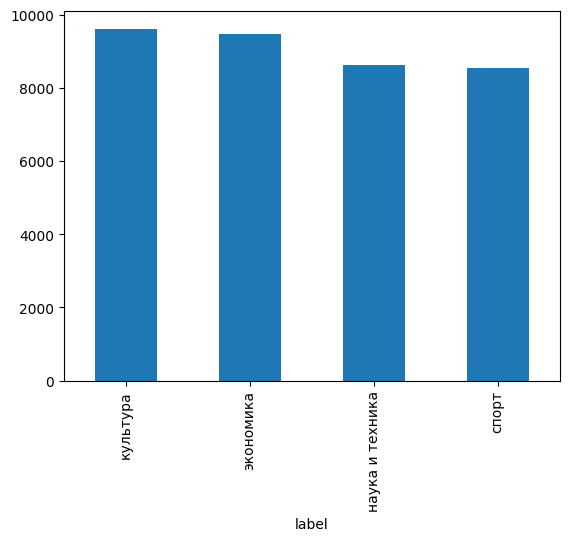

In [9]:
# Exploratory Data Analysis: https://www.kaggle.com/code/prithvijaunjale/t5-multi-label-classification
# Model: https://github.com/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb
df.lable.value_counts().plot.bar()

In [10]:
# model = transformers.T5ForConditionalGeneration.from_pretrained("cointegrated/rut5-base-absum")
tokenizer = transformers.T5Tokenizer.from_pretrained("cointegrated/rut5-base-absum")
print(pd.unique(df.label))
labels = pd.unique(df.label)
for label in labels:
    print(len(tokenizer.encode(label)))

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. If you see this, DO NOT PANIC! This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


['Экономика' 'Спорт' 'Культура' 'Наука и техника']
3
2
3
6


In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, test_size=0.20, random_state=42)
train_dataset = pd.concat([X_train, y_train], axis=1)
val_dataset = pd.concat([X_test,y_test], axis=1)

In [12]:
train_dataset.head()

,text,label
24047,мадонна прервала турне из за расстройства желу...,Культура
25551,пять дней проката войны миров стоили зрителям ...,Культура
12506,болельщики выбрали самых некрасивых игроков фу...,Спорт
15628,португальцы извинились перед овчинниковым за у...,Спорт
5665,государство гарантирует спокойный сон вкладчик...,Экономика


In [13]:
val_dataset.head()

,text,label
7801,налоговиков заставили отменить черный список б...,Экономика
17792,костя цзю я был слабее хаттона бывший абсолютн...,Спорт
843,выборы главы мвф будут безальтернативными перв...,Экономика
21971,константин хабенский переквалифицировался в жу...,Культура
15978,в москве действует 17 фанатских футбольных гру...,Спорт


In [14]:
train_dataset = DataT5(train_dataset.reset_index(), tokenizer)
val_dataset = DataT5(val_dataset.reset_index(), tokenizer)
print(f"{len(train_dataset)=}")
print(f"{len(val_dataset)=}")
data = train_dataset[42]
print(tokenizer.decode(data['source_ids'], skip_special_tokens=True))
print(tokenizer.decode(data['targets_ids'], skip_special_tokens=True))
le = LabelEncoder()
le.fit(df.label);

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/mnt/storage/kocharyan/sambashare/ITMO_LABS/ML/venv/local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/mnt/storage/kocharyan/sambashare/ITMO_LABS/ML/venv/l

len(train_dataset)=29007
len(val_dataset)=7252
на космическом телескопе решили сэкономить космический телескоп james webb который должен заменить hubble лишат части его возможностей в nasa склоняются к такому решению поскольку пока предполагаемая стоимость его создания на миллиард долларов превышает выделенные средства новый телескоп должен отправиться в космос не раньше 2011 года тогда как hubble по расчетам выйдет из строя уже в 2007 как выяснилось теперь даже после вывода на орбиту полноценной заменой своему предшественнику james webb не станет его чувствительность решили ограничить инфракрасным диапазоном отказавшись от оптического с этим намерением не согласны многие астрономы как заявил роберт о делл участник проекта hubble james webb и так уступает hubble с точки зрения наблюдений в видимом спектре и совсем отказаться от этой возможности означает оставить оптичесскую астрономию без главного инструмента на много лет сторонники облегченной версии james webb полагают что астрофизик

In [40]:
args_dict = dict(
    pretrain="cointegrated/rut5-base-absum",
    learning_rate=3e-4,
    weight_decay=0.01,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_bs=8,
    val_bs=16,
    epochs=10,
    gradient_accumulation_steps=16,
    n_gpu=1,
    le=le,
    task="multiclass",
    num_classes=len(pd.unique(df.label)),
    max_grad_norm=1.0,
)
args = argparse.Namespace(**args_dict)
train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    accelerator="gpu",
    devices=args.n_gpu,
    max_epochs=args.epochs,
    precision=16,
    gradient_clip_val=args.max_grad_norm,
)
     

In [41]:
def get_train_dataloader():
    return val_dataset # TODO: train_dataset

def get_val_dataloader():
    return val_dataset

model = GenreClassificationT5(args)

====>Init model...


In [42]:
trainer = pl.Trainer(**train_params)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [43]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                       | Params
--------------------------------------------------------
0 | model    | T5ForConditionalGeneration | 244 M 
1 | accuracy | MulticlassAccuracy         | 0     
2 | f1       | MulticlassF1Score          | 0     
--------------------------------------------------------
244 M     Trainable params
0         Non-trainable params
244 M     Total params
977.237   Total estimated model params size (MB)


====>Configure opt start...
====>Configure opt end...
====> Get train loader
Epoch 1:   3%|███▏                                                                                           | 30/906 [00:10<04:52,  3.00it/s, v_num=16, avg_train_loss=nan.0]

In [44]:
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


====> Get val loader
Testing DataLoader 0:   6%|██████▊                                                                                                           | 27/454 [00:06<01:43,  4.14it/s]